<a href="https://colab.research.google.com/github/maximecharriere/TM_PV_ADC/blob/main/00_Scripts/PVLibTestGeneration_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [ ]:
!pip install pvlib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvlib
import os
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
import plotly.graph_objects as go

PARENT_DATA_DIR = os.getenv('PARENT_DATA_DIR')


## Tiergarten_Ost Simulation

### System configuration

In [2]:
location = Location(latitude=47.062365389967134, longitude=7.614255071260409, altitude=533, tz='Europe/Zurich', name='Tiergarten_Ost')


In [3]:
#import the database
modules_database = pvlib.pvsystem.retrieve_sam(name='SandiaMod')
inverters_database = pvlib.pvsystem.retrieve_sam(name='cecinverter')

In [4]:
array1 = Array(
        mount=FixedMount(surface_tilt=30, surface_azimuth=241, racking_model = 'open_rack'),
        module_parameters={'pdc0': 55, 'gamma_pdc' : -0.004},
        module_type = 'glass_polymer',
        modules_per_string = 445, # 445 modules for 1 string or 89 modules for 5 strings is the same
        strings = 1,
        temperature_model_parameters=pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer'],
    )

system = PVSystem(arrays=[array1], inverter_parameters={'pdc0': 24475, 'eta_inv_nom': 0.96})

modelChain = ModelChain(system, location ,clearsky_model = 'ineichen', aoi_model='no_loss', spectral_model="no_loss")

### Minute clearsky irradiance power

In [5]:
times_minutes = pd.date_range(start='2022-01-01', end='2022-06-30', freq='5min', tz='UTC')
cs_minutes_power = location.get_clearsky(times_minutes)  # ineichen with climatology table by default


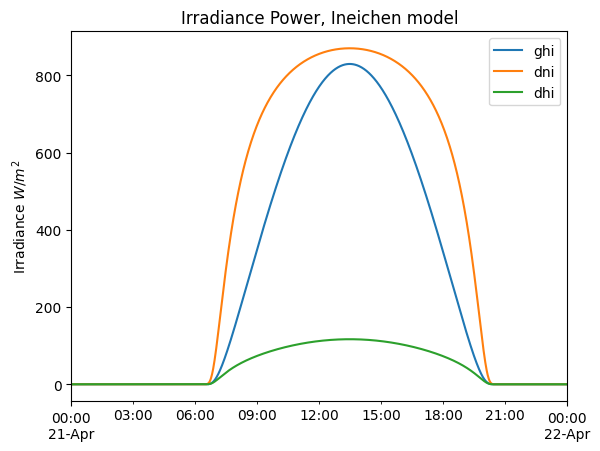

In [9]:
cs_minutes_power.plot();
plt.ylabel('Irradiance $W/m^2$');
plt.title('Irradiance Power, Ineichen model');

### AC Power

In [21]:
modelChain.run_model(cs_minutes_power)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: pvwatts_dc
  ac_model: pvwatts_inverter
  aoi_model: no_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

## Import measures

In [35]:
df_P_ac_L1 = pd.read_csv(PARENT_DATA_DIR+r"\BFH_Tiergarten_Ost_1PVS_1min\measurements\01_02_Tiergarten_Ost_P_ac_L1_2022.csv",
                         skiprows=3, parse_dates=['_start', '_time', '_stop'], nrows=70000)
df_P_ac_L2 = pd.read_csv(PARENT_DATA_DIR+r"\BFH_Tiergarten_Ost_1PVS_1min\measurements\01_02_Tiergarten_Ost_P_ac_L2_2022.csv",
                         skiprows=3, parse_dates=['_start', '_time', '_stop'], nrows=70000)
df_P_ac_L3 = pd.read_csv(PARENT_DATA_DIR+r"\BFH_Tiergarten_Ost_1PVS_1min\measurements\01_02_Tiergarten_Ost_P_ac_L3_2022.csv",
                         skiprows=3, parse_dates=['_start', '_time', '_stop'], nrows=70000)

In [36]:
df_P_ac = sum([df_P_ac_L1['_value'], df_P_ac_L2['_value'], df_P_ac_L3['_value']])


In [70]:
fig = go.Figure()

fig.add_trace(go.Scattergl(
    x=df_P_ac_L3['_time'], y=df_P_ac, name='P_ac', mode='markers'))
fig.add_trace(go.Scattergl(x=times_minutes, y=modelChain.results.ac, name='ModelChain', mode='markers'))

fig.update_layout(
    title="Time Series Visualization",
    xaxis_title="Time",
    yaxis_title="Value",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)
fig.show()


## PVLib pvwatts inverter model

This plot show the efficiency of a default inverter, depending of its reference DC power

In [ ]:
# Generate a range of values for Pdc and Pdc0
load = np.linspace(0.00001, 1.2, 100)
Pdc0 = np.ones(load.shape)*1000
Pdc = Pdc0*load
Pac = pvlib.inverter.pvwatts(pdc=Pdc, pdc0=Pdc0)
n = Pac/Pdc


In [ ]:
plt.plot(load, n, label='Inverter Efficiency')
plt.title('Inverter Efficiency vs Load')
plt.xlabel('Load (Pdc/Pdc0)')
plt.ylabel('Efficiency (Pac/Pdc)')
plt.grid(True)
plt.show()

## Daily energy

In [39]:
def daily_energy(df):
    # Get the frequency in minutes
    freq_in_minutes = pd.Timedelta(modelChain.results.ac.index.freq).seconds/60
    # Convert power from kW to kWh
    df_kWh = df * (freq_in_minutes/60)
    # Resample to daily frequency and sum the values
    daily_energy = df_kWh.resample('D').sum()
    return daily_energy


In [41]:
modelChain_daily_energy = daily_energy(modelChain.results.ac)